# Cuentas Falsas y Bots Usados Con Fines Políticos

## Reporte Inicial

## Recolección de tweets basada en cuentas (@) y Hashtags (#)

Usando el API de Twitter recoletamos **tweets publicados entre el 27 de Noviembre y el 4 de Diciembre de 2017**, que provengan de cuentas de pre-candidatos de los principales partidos políticos (ANR y PLRA), y/o contengan hashtags utilizados con fines electorales. Como base utilizamos las cuentas y hashtags publicados por el Diario Última Hora en su artículo [Perfiles de pre-candidatos según las redes](http://elecciones.ultimahora.com/informacion/?id=20). Por ejemplo, Última Hora reporta que el hashtag **#JuntosPodemosMas** es utilizado para identificar tweets vínculados al candidatos Santiago Peña de Honor Colorado. Así mismo, **#MaritoDeLaGente** se utilzan en tweets publicados en favor del candidato del movimiento Colorado Añeteté. Según Última Hora, el hashtag **#EsAhora** aparece en los tweets relacionados al pre-candidato a la presidencia por el PLRA, Efraín Alegre.

[Aquí](https://docs.google.com/spreadsheets/d/e/2PACX-1vQHoukfR9AFhSaz30QHYwKqpwexe1ASrW8ya25Fueh3jXcRPMSjrAyj4SbzryTLiuKkPdi6fsprqtM2/pubhtml) se puede acceder a lista completa de hashtags y cuentas.

## Tamaño del data set

In [1]:
%matplotlib inline

import os
import csv
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

os.chdir('..')

from db_manager import *
from data_wrangler import *

plt.style.use('seaborn')

In [2]:
db = get_db()
print('Se han recolectado {0} tweets y luego almacenados en una base de datos NoSQL (MongoDB) para facilitar su '\
      'análisis'.format(db.tweets.count()))

Se han recolectado 14640 tweets y luego almacenados en una base de datos NoSQL (MongoDB) para facilitar su análisis


## Limpieza de data set

Nos dimos cuenta que los hashtags que usamos para buscar tweets se utilizan también en otros contextos (en otros paises) por lo tanto para los análisis consideramos solo aquellos que además de los hashtags de interés contengan alguna mención a la cuenta de los candidatos

In [3]:
identify_relevant_tweets(db)
print('Seleccionamos {0} tweets que encontramos relevantes para el trabajo'.format(do_search(db, {'relevante': 1}).count()))

Seleccionamos 11731 tweets que encontramos relevantes para el trabajo


## Cantidad de Tweets por Interna

### ANR

In [4]:
tweets_anr = do_search(db, {'partido_politico': 'anr', 'relevante': 1})
print('Tweets relacionados a la interna ANR: {0}'.format(tweets_anr.count()))

Tweets relacionados a la interna ANR: 8290


### PLRA

In [5]:
tweets_plra = do_search(db, {'partido_politico': 'plra', 'relevante': 1})
print('Tweets relacionados a la interna PLRA: {0}'.format(tweets_plra.count()))

Tweets relacionados a la interna PLRA: 1765


Alrededor del 70% de los tweets colectados provienen de cuentas vinculadas a candidatos de la ANR y/o utilizan hashtags asociados a campañas del Partido Colorado.

## Internas: ANR

En un primer momento nos enfocaremos en los tweets relacionados a la internas de la ANR por ser mayoría en el data set. Exploraremos inicialmente la distribución de tweets considerando los dos movimiento más importantes en estas internas, es decir **Honor Colorado** y **Colorado Añeteté**.

## Distribución de tweets por movimiento

### Honor Colorado

In [6]:
tweets_hc = do_search(db, {'movimiento': 'honor colorado'})
print('Se publication {0} tweets relacionados al movimiento Honor Colorado ({1}% del total)'.
      format(tweets_hc.count(), round((tweets_hc.count()/tweets_anr.count())*100,2)))

tweets_sp = find_tweets_by_author(db, 'SantiPenap')
rtweets_sp = 0
for tweet_sp in tweets_sp:
    if 'retweeted_status' in tweet_sp['tweet_obj'].keys():
        rtweets_sp += 1
print('De los {0} tweets de Honor Colorado, Santiago Peña publicó {1} tweets ({2} retweets)'.
      format(tweets_hc.count(), tweets_sp.count(), rtweets_sp))

Se publication 4433 tweets relacionados al movimiento Honor Colorado (53.47% del total)
De los 4433 tweets de Honor Colorado, Santiago Peña publicó 10 tweets (0 retweets)


### Colorado Añetete

In [7]:
tweets_ca = do_search(db, {'movimiento': 'colorado añetete'})
print('Se publication {0} tweets relacionados al movimiento Colorado Añeteté ({1}% del total)'.
      format(tweets_ca.count(), round((tweets_ca.count()/tweets_anr.count())*100,2)))
tweets_ma = find_tweets_by_author(db, 'MaritoAbdo')
rtweets_ma = 0
for tweet_ma in tweets_ma:
    if 'retweeted_status' in tweet_ma['tweet_obj'].keys():
        rtweets_ma += 1
print('De los {0} tweets de Colorado Añetete, Mario Abdo publicó {1} tweets ({2} retweets)'.
      format(tweets_ca.count(), tweets_ma.count(), rtweets_ma))

Se publication 3675 tweets relacionados al movimiento Colorado Añeteté (44.33% del total)
De los 3675 tweets de Colorado Añetete, Mario Abdo publicó 70 tweets (11 retweets)


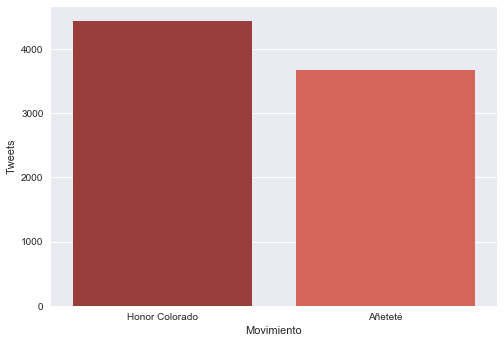

In [8]:
tweets_por_movimiento = pd.DataFrame({
    'Movimiento': ['Honor Colorado', 'Añeteté'],
    'Tweets': [tweets_hc.count(), tweets_ca.count()]
}, index=['hc', 'ca'])
sns.barplot(x='Movimiento', y='Tweets', data=tweets_por_movimiento, palette="Reds_d")

Los tweets relacionados al movimiento *Honor Colorado* constituyen más del 50% de nuestro data set mientras que los vinculados a las candidaturas del movimiento *Colorado Añeteté* representan casi el 45% del total de datos. El restante porcentaje pertence a tweets vínculados a las internas de la ANR pero no necesariamente a uno de estos dos movimiento, por ejemplo, tweets que utilizan solamente el hashtag **#InternasANR**.

## Distribución de tweets sobre candidato

Para este análisis solo se tuvieron en cuenta los tweets que contienen hashtags orientadas principalmente a promocionar la figura del candidato no el movimiento o partido al que pertenece. Por ejemplo, los hashtags **#JuntosPodemosMas** o **#CaminandoJuntos** son hashtags vinculados principalmente a la figura de Santiago Peña no así el hashtag **#HonorColorado** que se utiliza para promocionar el movimiento partidario pero no necesariamente la candidatura de Peña. Aquí consideramos solo los primeros, es decir, aquellos vinculados directamente al candidato.

* Hashtags relacionados directamente con la campaña de Peña y que se consideraron para este análisis: #CaminandoJuntos, #JuntosHagamosMas, #SigamosConversando

* Hashtags relacionados directamente con la campaña de Abdo y que se consideraron para este análisis: #MaritoDeLaGente, #ParaguayDeLaGente

En los siguientes análisis no se tendrán en cuenta los tweets publicados por los candidatos. Esto es, los 10 tweets publicados por Santiago Peña y los 70 tweets publicados por Mario Abdo.

### Santiago Peña

In [9]:
tweets_sp = do_search(db, {'candidatura': 'santiago peña', 'tweet_obj.user.screen_name': {'$ne':'SantiPenap'}})
print('Tweets relacionados al candidato Santiago Peña: ' \
      '{0} ({1}% del total del movimiento HC)'.format(tweets_sp.count(), 
                                                      round((tweets_sp.count()/tweets_hc.count())*100,2)))

Tweets relacionados al candidato Santiago Peña: 2169 (48.93% del total del movimiento HC)


### Mario Abdo Benítez

In [10]:
tweets_ma = do_search(db, {'candidatura': 'mario abdo', 'tweet_obj.user.screen_name': {'$ne':'MaritoAbdo'}})
print('Tweets relacionados al candidato Mario Abdo: ' \
      '{0} ({1}% del total del movimiento Colorado Añeteté)'.format(tweets_ma.count(), 
                                                      round((tweets_ma.count()/tweets_ca.count())*100,2)))

Tweets relacionados al candidato Mario Abdo: 3246 (88.33% del total del movimiento Colorado Añeteté)


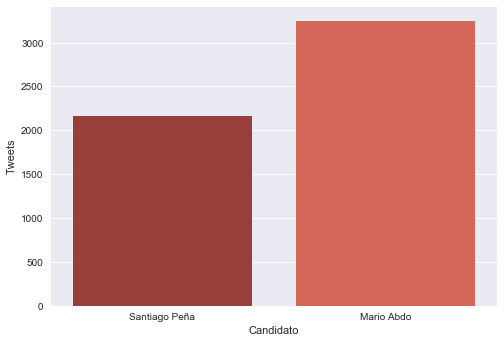

In [11]:
tweets_por_candidato = pd.DataFrame({
    'Candidato': ['Santiago Peña', 'Mario Abdo'],
    'Tweets': [tweets_sp.count(), tweets_ma.count()]
}, index=['sp', 'ma'])
sns.barplot(x='Candidato', y='Tweets', data=tweets_por_candidato, palette="Reds_d")

Este resultado es interesante. Muestra una diferencia de enfoques en las campañas en redes de ambos movimientos. **La campaña del movimiento *Colorado Añeteté* se centra principalmente en el candidato a presidente Mario Abdo Benítez, casi el 90% de los tweets éstan vinculados a su figura**. Por otra parte, la campañan de *Honor Colorado* se enfoca más en el  movimiento en si y no tanto en Peña. Quizás el pasado liberal del candidato oficialista puede estar influenciando la estraegia de HC.

## Hashtags más populares usados por los movimientos

### Honor Colorado

In [12]:
hashtags_hc = get_hashtags_by_movement(db, 'honor colorado', include_candidate=False, candidate_handler='SantiPenap')
hashtags_populares_hc = []
for hashtag in hashtags_hc:
    por_total = round((hashtag['count']/tweets_hc.count())*100)
    hashtag_dict = {'1. Hashtag': '#' + hashtag['_id'], '2. Cantidad de Tweets': hashtag['count'], 
                    '3. % Total de HC': str(por_total) + '%'}
    hashtags_populares_hc.append(hashtag_dict)
pd.DataFrame(hashtags_populares_hc)

,1. Hashtag,2. Cantidad de Tweets,3. % Total de HC
0,#HonorColorado,762,17%
1,#SigamosConversando,402,9%
2,#CaminandoJuntos,46,1%
3,#JuntosPodemosMas,6,0%


### Colorado Añeteté

In [13]:
hashtags_ca = get_hashtags_by_movement(db, 'colorado añetete', include_candidate=False, candidate_handler='MaritoAbdo')
hashtags_populares_ca = []
for hashtag in hashtags_ca:
    por_total = round((hashtag['count']/tweets_hc.count())*100)
    hashtag_dict = {'1. Hashtag': '#' + hashtag['_id'], '2. Cantidad de Tweets': hashtag['count'], 
                    '3. % Total de Añeteté': str(por_total) + '%'}
    hashtags_populares_ca.append(hashtag_dict)
pd.DataFrame(hashtags_populares_ca)

,1. Hashtag,2. Cantidad de Tweets,3. % Total de Añeteté
0,#ParaguayDeLaGente,1498,34%
1,#MaritoDeLaGente,915,21%
2,#Lista3,833,19%
3,#ColoradoAñetete,198,4%


Estos resultados son consistentes con los anteriores ya que muestran como **la campaña del movimiento HC está principalmente enfocada en dar promoción al movimiento antes que al candidato**.

## Cantidad de tuiteros por movimiento

### Honor Colorado

In [14]:
unique_users_hc = get_unique_users_by_movement(db, 'honor colorado', include_candidate=False, 
                                               candidate_handler='SantiPenap')
print('{0} usuarios tuitearon sobre Honor Colorado'.format(len(unique_users_hc)))

1687 usuarios tuitearon sobre Honor Colorado


#### Top-10 más activos con sus actividades

In [15]:
top10_tuiteros_hc = []
for i in range(10):
    tuitero_hc = {'1.Usuario': unique_users_hc[i]['screen_name'], 
                  '2.Tweets': unique_users_hc[i]['tweets_count'],
                  '3.Originales': unique_users_hc[i]['original_count'],
                  '4.Retweets': unique_users_hc[i]['retweets_count'],
                  '5.Quotes': unique_users_hc[i]['quotes_count'],
                  '6.Replies': unique_users_hc[i]['replies_count'],
                  '7.Followers': unique_users_hc[i]['followers'],
                  '8.Friends': unique_users_hc[i]['friends']}
    top10_tuiteros_hc.append(tuitero_hc)
pd.DataFrame(top10_tuiteros_hc)

,1.Usuario,2.Tweets,3.Originales,4.Retweets,5.Quotes,6.Replies,7.Followers,8.Friends
0,ArturoO22734057,52,0,52,0,0,189,795
1,Michelec1954,45,0,0,43,2,705,1483
2,delgapy2016,45,0,45,0,0,76,460
3,silvatadeo2,42,0,40,0,2,10,53
4,miryangonza,41,0,39,0,2,11,55
5,alilebron45,40,0,39,0,1,11,64
6,saguierangel,40,0,39,0,1,10,53
7,JudithGimnez2,39,0,38,0,1,11,114
8,Mariade84654356,36,0,36,0,0,9,77
9,aristiqui85,35,0,33,0,2,245,224


### Colorado Añeteté

In [16]:
unique_users_ca = get_unique_users_by_movement(db, 'colorado añetete', include_candidate=False, 
                                               candidate_handler='MaritoAbdo')
print('{0} usuarios tuitearon sobre Colorado Anetete'.format(len(unique_users_ca)))

748 usuarios tuitearon sobre Colorado Anetete


#### Top-10 más activos y sus actividades

In [17]:
top10_tuiteros_ca = []
for i in range(10):
    tuitero_ca = {'1.Usuario': unique_users_ca[i]['screen_name'], 
                  '2.Tweets': unique_users_ca[i]['tweets_count'],
                  '3.Originales': unique_users_ca[i]['original_count'],
                  '4.Retweets': unique_users_ca[i]['retweets_count'],
                  '5.Quotes': unique_users_ca[i]['quotes_count'],
                  '6.Replies': unique_users_ca[i]['replies_count'],
                  '7.Followers': unique_users_ca[i]['followers'],
                  '8.Friends': unique_users_ca[i]['friends']}
    top10_tuiteros_ca.append(tuitero_ca)
pd.DataFrame(top10_tuiteros_ca)

,1.Usuario,2.Tweets,3.Originales,4.Retweets,5.Quotes,6.Replies,7.Followers,8.Friends
0,Paraguaynosune,205,0,205,0,0,502,173
1,jjrios_bogado,85,0,76,0,9,1857,777
2,Solmelga,84,0,62,0,22,5287,4788
3,Beatriz20D,55,0,55,0,0,206,739
4,EDITHVILLA3,55,0,54,0,1,589,1118
5,felixugarte,53,0,53,0,0,496,368
6,equipo_anetete,52,0,46,0,6,3504,812
7,MichellMCord,52,0,43,4,5,75,474
8,FaroveFatima,49,0,49,0,0,973,906
9,Villa3Edith,42,0,42,0,0,273,381


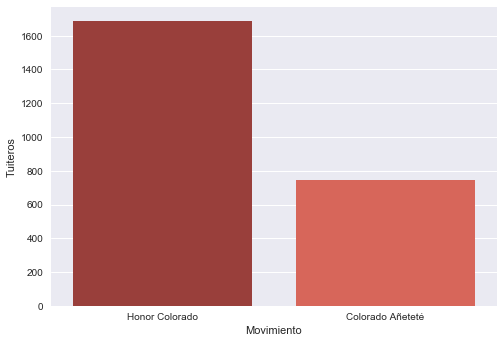

In [18]:
tuiteros_por_movimiento = pd.DataFrame({
    'Movimiento': ['Honor Colorado', 'Colorado Añeteté'],
    'Tuiteros': [len(unique_users_hc), len(unique_users_ca)]
}, index=['hc', 'ca'])
sns.barplot(x='Movimiento', y='Tuiteros', data=tuiteros_por_movimiento, palette="Reds_d")

Como se podría esperar el ejercito de tuiteros del movimiento *Honor Colorado* es ampliamente superior al de *Colorado Añeteté*. Prácticamente, **por cada tuitero de *Colorado Añeteté* existen casi 2.5 tuiteros de *Honor Colorado***. Sin embargo la diferencia en cantidad de tweets entre ambos movimiento no es muy importante, como vimos anteriormente, lo que demuestra que *Colorado Añeteté* tiene un ejercito más activo de tuiteros.

Otro aspecto destacable del último análisis es el tipo de actividad que realizan tanto los tuiteros de *Honor Colorado* como los de *Añeteté*. En ambos casos, **los tuiteros más activos no publican nuevo tweets** sino se limitan a casi exclusivamente a retuitear tweets vinculados a su movimiento. En otras palabras, la principal actividad de estos usuarios es amplificar y promocionar información relacionada a sus intereses. **Este comportamiento es típico de bots y cuentas falsas**. La siguiente tarea en el estudio consistirá, por lo tanto, en análizar más en detalle el comportamiento de estas cuentas con el objetivo de verificar si son falsas o se encuentran vínculadas a sistemas automáticos de publicaciones. 